# Metody programowania równoległego
Temat: OpenMP - sortowanie kubełkowe

**Adam Klekowski, Paweł Kruczkiewicz**

In [198]:
import pandas as pd
import matplotlib as plt

## A. Opis algorytmów równoległych

### Algorytm 1 (Paweł Kruczkiewicz)

### Algorytm 2 (Adam Klekowski)

## B. Badanie algorytmu sekwencyjnego
### B1. Dobór wielkości kubełka
Pomiarów dokonano na maszynie Ares na 1 rdzeniu procesora.
Wykonano po 20 pomiarów dla różnych wielkości problemu (10 000, 100 000, 1 000 000, 10 000 000) i rozmiarów koszyka (10, 100, 1 000, 10 000). Wyniki dla każdej konfiguracji uśredniono.

In [199]:
bucket_sort_df = pd.read_csv("bucket_sort_ver_1.csv")
bucket_sort_df = bucket_sort_df.loc[bucket_sort_df['P'] == 1]
bucket_sort_df = bucket_sort_df[['N', 'B', 'T_E']].groupby(by=["N", "B"]).mean()
bucket_sort_df.head(16)

T_E
N        B              
10000    10     0.002099
         100    0.001424
         1000   0.000993
         10000  0.000979
100000   10     0.023464
         100    0.018765
         1000   0.013695
         10000  0.009608
1000000  10     0.282219
         100    0.233372
         1000   0.189512
         10000  0.149120
10000000 10     3.317078
         100    2.837405
         1000   2.415077
         10000  2.160757

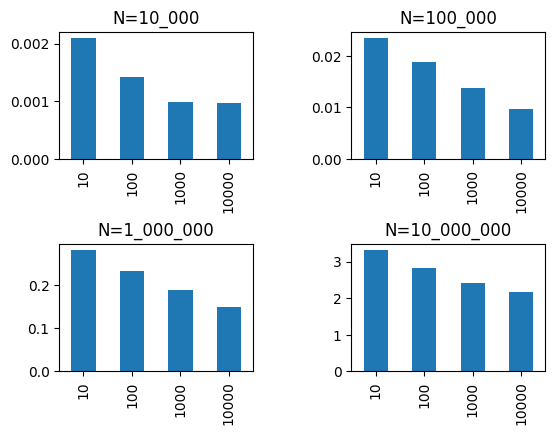

In [200]:
bucket_sort_df = bucket_sort_df.reset_index()
fig, ((ax1, ax2), (ax3, ax4)) = plt.pyplot.subplots(2, 2)
fig.tight_layout(pad=4.0)

ax = bucket_sort_df.loc[bucket_sort_df['N'] == 10_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax1,legend=None, title="N=10_000", xlabel="")
ax = bucket_sort_df.loc[bucket_sort_df['N'] == 100_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax2,legend=None, title="N=100_000", xlabel="")
ax = bucket_sort_df.loc[bucket_sort_df['N'] == 1_000_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax3,legend=None, title="N=1_000_000", xlabel="")
ax = bucket_sort_df.loc[bucket_sort_df['N'] == 10_000_000][['B', 'T_E']].set_index('B').plot.bar(ax=ax4,legend=None, title="N=10_000_000", xlabel="")

Zwiększanie liczby kubełków zmniejszyło czas sortowania dla każdego rozmiaru problemu.

### B2. Rozkład generatora liczb losowych

Przy użyciu generator liczb losowych `erand48` wygenerowano i zapisano do pliku 1 000 000 wartości. Następnie narysowano histogram uzyskanych wartości dla 10 przedziałów (kolor czerwony) oraz 100 przedziałów (kolor niebieski).

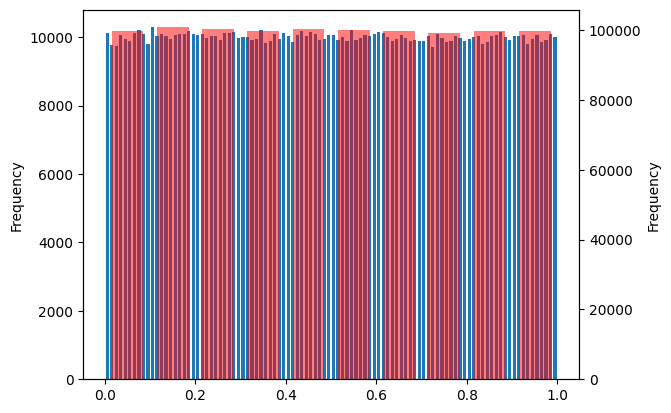

In [201]:
erand48_df = pd.read_csv("erand48_test.csv")
fig, ax_0 = plt.pyplot.subplots()
ax_1 = ax_0.twinx()

_ = erand48_df.plot.hist(ax=ax_0, bins=100, rwidth=.7, legend=None)
_ = erand48_df.plot.hist(ax=ax_1, bins=10, rwidth=.7, legend=None, color='red', alpha=0.5)

Generator `erand48` losuje wartości równomiernie z całego przedziału [0.0, 1.0).

## C. Badanie jakości algorytmów równoległych

Pomiarów dokonano na maszynie Ares. Wykonano po 20 pomiarów dla różnych wielkości problemu (10 000, 100 000, 1 000 000, 10 000 000), rozmiarów koszyka (10, 100, 1 000, 10 000) i liczby proceserów (1, 2, 3, 4). Wyniki dla każdej konfiguracji uśredniono.

In [202]:
bucket_sort_ver_1 = pd.read_csv("bucket_sort_ver_1.csv")
bucket_sort_ver_1.insert(loc=0, column='algorithm ver.', value=1)

bucket_sort_ver_2 = pd.read_csv("bucket_sort_ver_2.csv")
bucket_sort_ver_2.insert(loc=0, column='algorithm ver.', value=2)
df = bucket_sort_ver_1.merge(bucket_sort_ver_2, how='outer')
df = df[['algorithm ver.', 'N', 'B', 'P', 'T_A', 'T_B', 'T_C', 'T_D', 'T_E']].groupby(by=['algorithm ver.', "N", "B", "P"]).mean().reset_index()

### C1. Czas sortowania w zależności od liczby procesorów

In [203]:
def plot_total_time(df, P, ax):
  return df.loc[(df['P'] == P) & (df['N'] == 10_000_000) & (df['B'] == 10_000)][['algorithm ver.', 'T_E']].set_index('algorithm ver.').plot.bar(ax=ax, stacked=True, title=f'{P=}', ylim=(0, 2.5), position=1, width=0.2, color='y')

def plot_compontents_time(df, P, ax):
  return df.loc[(df['P'] == P) & (df['N'] == 10_000_000) & (df['B'] == 10_000)][['algorithm ver.', 'T_A', 'T_B', 'T_C', 'T_D']].set_index('algorithm ver.').plot.bar(ax=ax, stacked=True, legend='reverse', ylim=(0, 2.5), position=0, width=0.2)

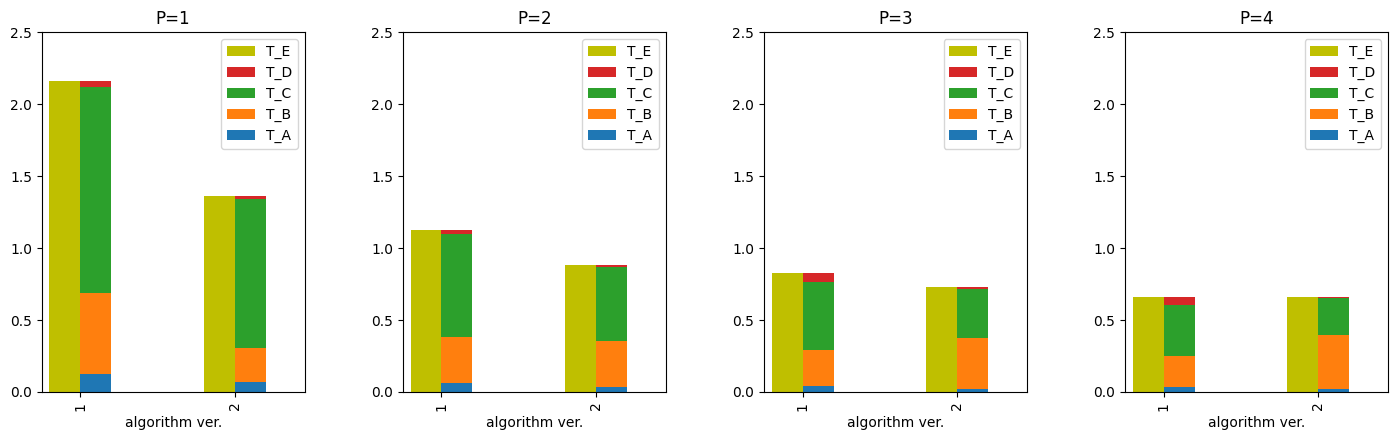

In [204]:
fig, axs = plt.pyplot.subplots(1, 4)
fig.set_size_inches(15, 5)
fig.tight_layout(pad=4.0)

for p in range(4):
  plot_total_time(df, p+1, axs[p])
  plot_compontents_time(df, p+1, axs[p])

### C2. Przyspieszenie w zależności od liczby procesorów

In [205]:
df_1 = df.loc[(df['N'] == 10_000_000) & (df['B'] == 10_000) & (df['algorithm ver.'] == 1)].copy()
for value in ['T_A', 'T_B', 'T_C', 'T_D', 'T_E']:
  value_1 = df_1.iloc[0][value]
  df_1[f"speedup_{value}"] = value_1 / df_1[value]
df_1.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E,speedup_T_A,speedup_T_B,speedup_T_C,speedup_T_D,speedup_T_E
60,1,10000000,10000,1,0.124491,0.560401,1.433030,0.042834,2.160757,1.000000,1.000000,1.000000,1.000000,1.000000
61,1,10000000,10000,2,0.062637,0.321467,0.715726,0.024330,1.124159,1.987500,1.743264,2.002204,1.760588,1.922109
62,1,10000000,10000,3,0.041241,0.247598,0.478074,0.057090,0.824004,3.018594,2.263349,2.997503,0.750300,2.622265
63,1,10000000,10000,4,0.031131,0.214602,0.357758,0.056500,0.659992,3.998954,2.611352,4.005579,0.758126,3.273916


In [206]:
df_2 = df.loc[(df['N'] == 10_000_000) & (df['B'] == 10_000) & (df['algorithm ver.'] == 2)].copy()
for value in ['T_A', 'T_B', 'T_C', 'T_D', 'T_E']:
  value_1 = df_2.iloc[0][value]
  df_2[f"speedup_{value}"] = value_1 / df_2[value]
df_2.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E,speedup_T_A,speedup_T_B,speedup_T_C,speedup_T_D,speedup_T_E
124,2,10000000,10000,1,0.065082,0.242818,1.029393,0.025733,1.363026,1.000000,1.000000,1.000000,1.000000,1.000000
125,2,10000000,10000,2,0.033533,0.317879,0.515669,0.012940,0.880021,1.940853,0.763867,1.996229,1.988583,1.548855
126,2,10000000,10000,3,0.022625,0.351945,0.343765,0.008660,0.726997,2.876514,0.689930,2.994463,2.971378,1.874872
127,2,10000000,10000,4,0.017253,0.378048,0.257673,0.006529,0.659503,3.772320,0.642292,3.994955,3.941327,2.066747


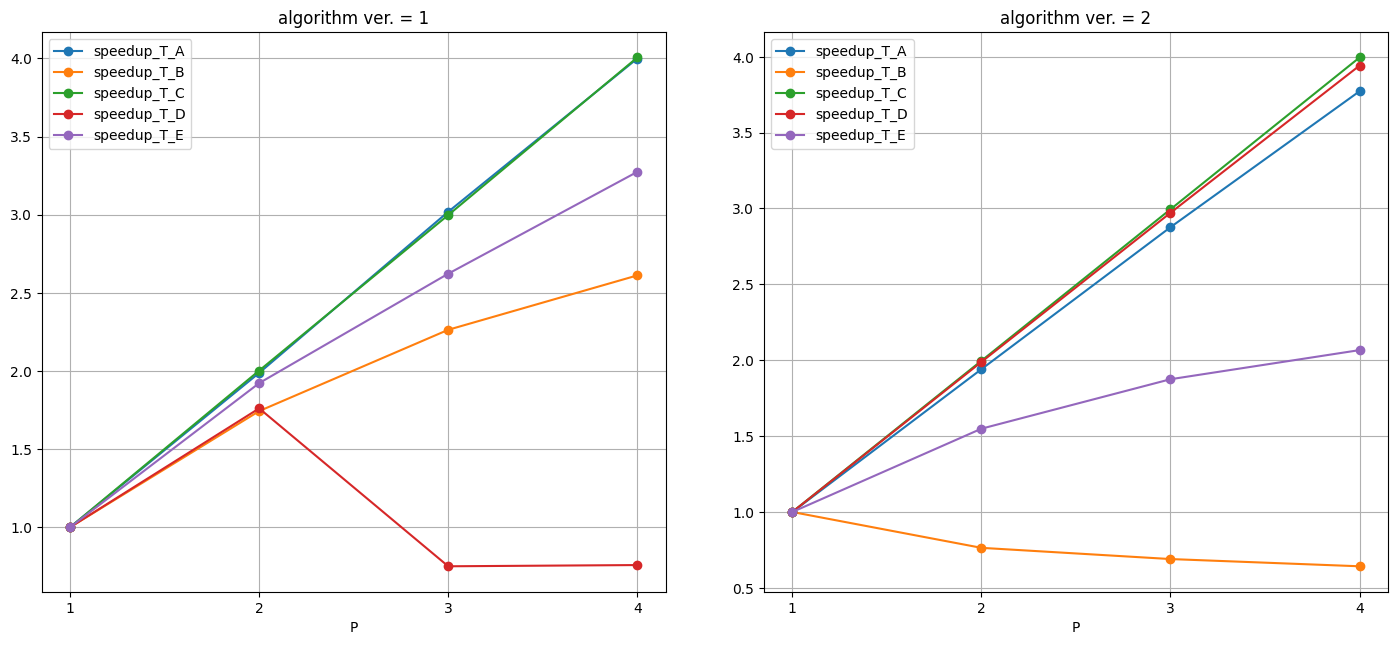

In [207]:
fig, ((ax1, ax2)) = plt.pyplot.subplots(1, 2)
fig.set_size_inches(15, 7)
fig.tight_layout(pad=4.0)

common_config = {'linestyle': '-', 'marker': 'o', 'x': 'P', 'xticks':range(1, 5, 1), 'grid':'both'}
for y in ['speedup_T_A', 'speedup_T_B', 'speedup_T_C', 'speedup_T_D', 'speedup_T_E']:
  df_1.plot(ax=ax1, y=y, **common_config, title='algorithm ver. = 1')
for y in ['speedup_T_A', 'speedup_T_B', 'speedup_T_C', 'speedup_T_D', 'speedup_T_E']:
  df_2.plot(ax=ax2, y=y, **common_config, title='algorithm ver. = 2')